# Analysis of local search behavior elicited by optogenetic stimuluation
### Analysis of single flyVR trials 
### Assumes use of FlyOver version 1.0.7 or higher

In [19]:
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
    
from os import listdir, mkdir, walk, getcwd
from os.path import isfile, sep, exists
from sys import path, exit
from glob import glob
from operator import itemgetter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

# Import custom plotting functions
from plottingUtilities.basicPlotting import myAxisTheme, timeAxisTheme, niceScatterPlot, makeNestedPlotDirectory
from plottingUtilities.flyTracePlots import plotPosInRange, plotFlyVRtimeStp, plotPolarTrace
from plottingUtilities.velocityDistributionPlots import plotVeloHistogram_fancy, velocitySummaryPlot
from plottingUtilities.objectInteractionPlots import modulationOfRuns,residencyWithHistograms_splitOnWalking, curvatureVsHeading_DistanceBoxplot, plotResidencyInMiniarena

# Import custom data processing functions
from flyVR.utilities.loadSingleTrial import loadSingleVRLogfile, rZoneParamsFromLogFile
from flyVR.utilities.loadObjectCoords import loadObjectCoordAllIdentities

from trajectoryAnalysis.downsample import donwsampleFOData
from trajectoryAnalysis.trajectoryDerivedParams import convertRawHeadingAngle, velocityFromTrajectory, relationToObject, cartesian2polar, polarCurvature
from trajectoryAnalysis.periodicWorldAnalysis import collapseTwoObjGrid, collapseToMiniArena

sns.set_style('ticks')

%matplotlib inline 

# Choose file to analyse ..............................................................................................

baseDir = '/Users/haberkernh/Desktop/localSearch/Gr64f-doubleGal4_x_10xChrimsonR/'
#'/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/localSearch/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
expDir = askdirectory(initialdir=baseDir, title='Select experiment directory of a single fly') + sep
root.update()
root.destroy()

dataDir = sep.join(expDir.split(sep)[0:-2]) + sep

FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
FODataFiles = sorted(FODataFiles)

print('\n Analysing the following log files:\n')
print(FODataFiles)


 Analysing the following log files:

['singleObjectForest_invLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f05_25h_6-9d_180910180728.txt', 'singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f01_24h_9d_180909170029.txt', 'singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f02_25h_9d_180909172526.txt', 'singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f03_26h_9d_180909184521.txt', 'singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f04_24h_10d_180910163546.txt', 'singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f05_24h_6-9d_180910170356.txt', 'singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f06_26h_6-9d_180910184052.txt', 'singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f07_24h_7-10d_180911161226.txt', 'singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f08_24h_7-10d_180911163951.txt', 'singleObjectForest_v

In [61]:
analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    mkdir(analysisDir)
except OSError:
    print('Analysis directory already exists.')

Analysis directory already exists.


### Load raw data
#### Choose trial to analyse

In [105]:
trial = 8#adjust
FODataFile = FODataFiles[trial]
FODataFile

'singleObjectForest_visLM_1cm4cmCone_12cmHex_Gr64f-double-Gal4_x_10xChrR_f08_24h_7-10d_180911163951.txt'

In [106]:
dataFileParts = FODataFile.split('_')

genotype = '_'.join(dataFileParts[4:7])
trialType = dataFileParts[1]
settings = dataFileParts[8]
stimDuration = '200 ms'

flyID = dataFileParts[-4]
    
titleString = genotype + ' fly "' + flyID + '" in ' + dataFileParts[0] + '-' +trialType + ' with settings ' + settings + ' and ' \
              + stimDuration + ' pulses'
print(titleString)

Gr64f-double-Gal4_x_10xChrR fly "f08" in singleObjectForest-visLM with settings 24h and 200 ms pulses


#### Read in logfile data, parse header

In [107]:
header, FOData, numFrames, frameRange, calibParams, coordFile = loadSingleVRLogfile(expDir, FODataFile)

In [108]:
visibleObjectCoords, visibleObjectName, invisibleObjectCoords, invisibleObjectName, origin = \
        loadObjectCoordAllIdentities(dataDir, coordFile)

### Compute movement velocities

In [109]:
logTime = np.copy(FOData[:, 0])
time = np.linspace(0, logTime[-1], numFrames)

angle = convertRawHeadingAngle(FOData[:, 5])

#### Downsample data to 20 Hz

In [110]:
samplingRate = 20
time_ds, xPos_ds, yPos_ds, angle_ds, numFrames_ds\
    = donwsampleFOData(samplingRate, logTime, time, FOData[:, 1], FOData[:, 2], angle)

#### ... and compute downsampled velocities

In [111]:
N = 5
vTrans_ds, vRot_ds, vTransFilt_ds, vRotFilt_ds\
    = velocityFromTrajectory(time_ds, angle_ds, xPos_ds, yPos_ds, N, numFrames_ds)

### Generate basic analysis plots
#### Time step plot

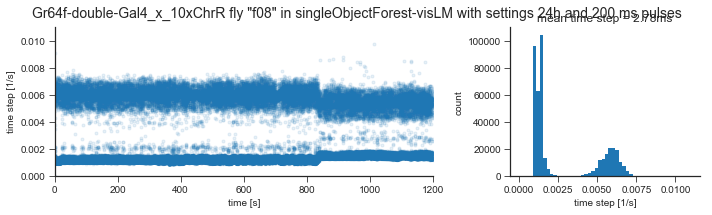

In [112]:
plotStp = 5
tstpfig = plotFlyVRtimeStp(plotStp, FOData[:, 0], titleString)

In [113]:
makeNestedPlotDirectory(analysisDir, 'timeStepPlot/', trialType + 'Trial'  + sep)

tstpfig.savefig(analysisDir + 'timeStepPlot/' + trialType + 'Trial'  + sep
                + FODataFile[0:-4] + '_timeStepPlot.pdf', format='pdf')

Analysis directory already exists.
Plot directory already exists.


#### Plot of walking trace (+ colorbar for time) with object locations

In [114]:
dotShape = np.asarray([bool('Dot' in objName) for objName in visibleObjectName])
rewardZones = np.asarray([bool('z' in objName) for objName in invisibleObjectName])

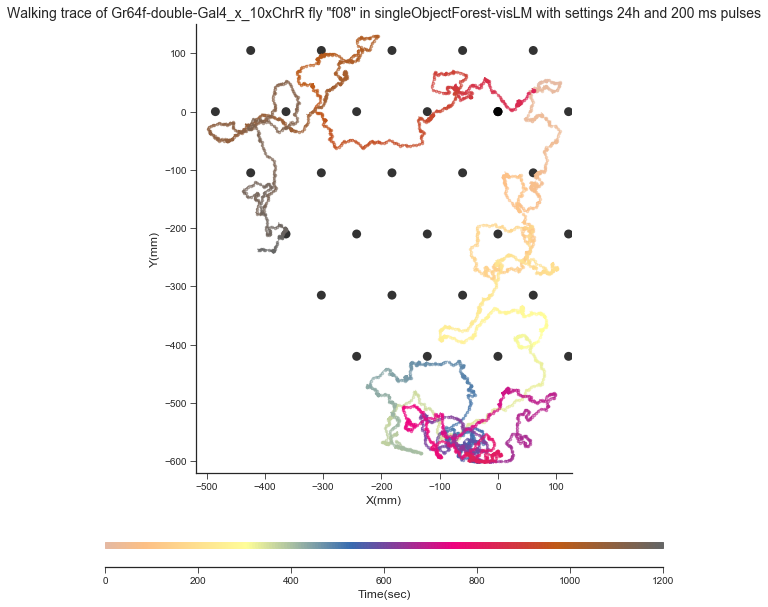

In [115]:
tStart = 0
tEnd = len(FOData[:, 1])
tStep = 120#72
frameRange = range(tStart, tEnd, tStep)
colMap = 'Accent'
arrowLength = 4

trajfig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=np.hstack((10, 1)))

axTraj = trajfig.add_subplot(gs[0])
axTime = trajfig.add_subplot(gs[1])

plotPosInRange(axTraj, axTime, frameRange, FOData[:, 0], FOData[:, 1], FOData[:, 2], np.pi/180*FOData[:, 5],
               colMap, arrowLength, 0.5, 5)
axTraj.scatter(visibleObjectCoords[:, 0], visibleObjectCoords[:, 1], 80, alpha=0.8,
               facecolors='black', edgecolors='none', marker = 'o')
#axTraj.scatter(invisibleObjectCoords[rewardZones, 0], invisibleObjectCoords[rewardZones, 1], 50, alpha=0.5,
#               facecolors='none', edgecolors='black', marker = 'o')
axTraj.set_xlabel(header[1], fontsize=12)
axTraj.set_ylabel(header[2], fontsize=12)
axTraj.set_title('Walking trace of ' + titleString, fontsize=14)
#axTraj.set_xlim([-200, 200])
#axTraj.set_ylim([-50, 400])
axTraj.set_xlim([max(-650, min(FOData[:, 1]) - 20), min(650, max(FOData[:, 1]) + 20)])
axTraj.set_ylim([max(-650, min(FOData[:, 2]) - 20), min(650, max(FOData[:, 2]) + 20)])
myAxisTheme(axTraj)

axTime.set_xlabel(header[0], fontsize=12)
plt.xlim((0, FOData[-1, 0]))
timeAxisTheme(axTime)

In [116]:
makeNestedPlotDirectory(analysisDir, 'tracePlot/',trialType + 'Trial'  + sep)

trajfig.savefig(analysisDir + 'tracePlot/' + trialType + 'Trial' + sep
                + FODataFile[0:-4] + '_traceObjectPlot.pdf', format='pdf')

Analysis directory already exists.
Plot directory already exists.


#### Visualise strength of optogenetic stimulation

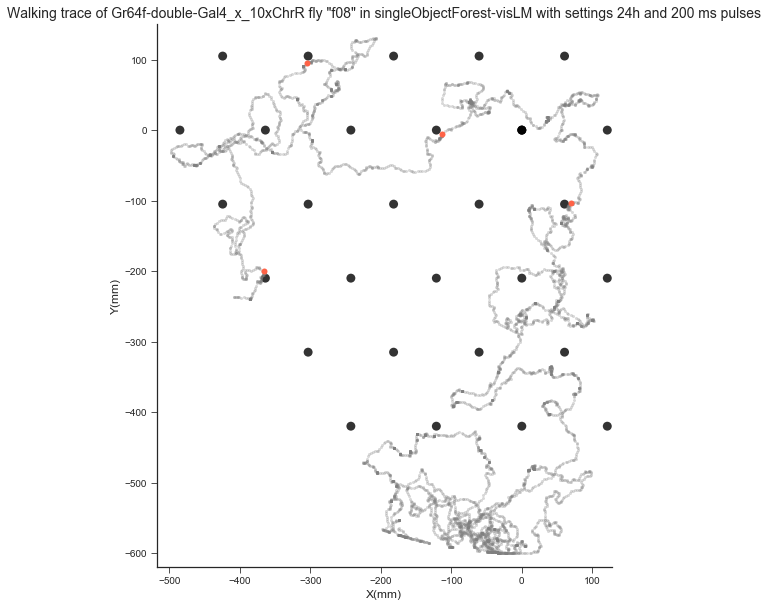

In [117]:
rEvents = FOData[:,11]

tStep = 72
frameRange = range(tStart, tEnd, tStep)

trajRZfig = plt.figure(figsize=(10, 10))
axTraj = trajRZfig.add_subplot(111)

axTraj.scatter(visibleObjectCoords[:, 0], visibleObjectCoords[:, 1], 80, alpha=0.8,
               facecolors='black', edgecolors='none', marker = 'o')

axTraj.plot(FOData[frameRange, 1], FOData[frameRange, 2], marker='.', markerfacecolor='grey',
         markeredgecolor='none', linestyle='none', alpha=0.3)

#overlay reinforcement val
axTraj.plot(FOData[frameRange, 1][rEvents[frameRange]>0], 
            FOData[frameRange, 2][rEvents[frameRange]>0],
            marker='o', markerfacecolor='tomato', markeredgecolor='none', 
            linestyle='none')

axTraj.set_xlabel(header[1], fontsize=12)
axTraj.set_ylabel(header[2], fontsize=12)
axTraj.set_title('Walking trace of ' + titleString, fontsize=14)
#axTraj.set_xlim([-200, 200])
#axTraj.set_ylim([-50, 400])
axTraj.set_xlim([max(-650, min(FOData[:, 1]) - 20), min(650, max(FOData[:, 1]) + 20)])
axTraj.set_ylim([max(-650, min(FOData[:, 2]) - 20), min(650, max(FOData[:, 2]) + 20)])
axTraj.set_aspect('equal')
myAxisTheme(axTraj)

In [118]:
makeNestedPlotDirectory(analysisDir, 'tracePlotRZ/', trialType + 'Trial' + sep)

trajRZfig.savefig(analysisDir + 'tracePlotRZ/' + trialType + 'Trial' + sep
                + FODataFile[0:-4] + '_traceObjectPlot.pdf', format='pdf')

Analysis directory already exists.
Plot directory already exists.


#### Plot velocity distributions of downs sampled data

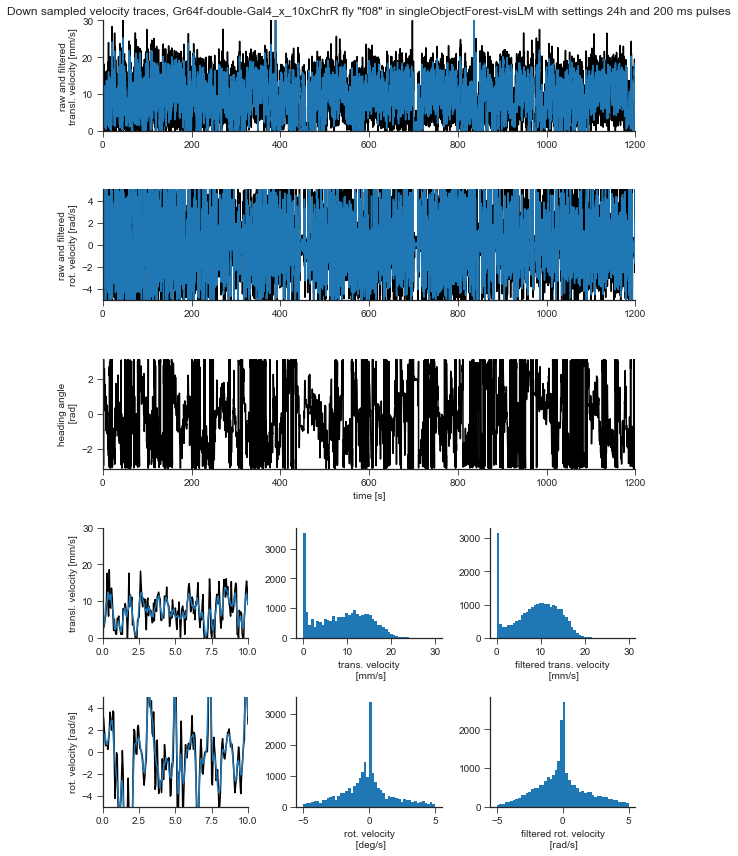

In [119]:
rotLim = (-5, 5)
transLim = (0, 30)
angleLim = (-np.pi, np.pi)
summaryVeloFig_ds = velocitySummaryPlot(time_ds, vTrans_ds, vTransFilt_ds, vRot_ds, vRotFilt_ds, angle_ds, rotLim,
                                        transLim, angleLim, 'Down sampled velocity traces, ' + titleString)

In [120]:
makeNestedPlotDirectory(analysisDir, 'velocityTraces/', trialType + 'Trial'  + sep)

summaryVeloFig_ds.savefig(analysisDir + 'velocityTraces/' + trialType + 'Trial'  + sep
                          + FODataFile[0:-4] + '_veloTraces_ds.pdf', format='pdf')

Analysis directory already exists.
Plot directory already exists.


### Collapse traces to single object cell and plot resulting trace
#### Collapse to 'mini-arena' while preserving the global heading

In [121]:
arenaRad = 60
objectCoords = invisibleObjectCoords[rewardZones,:]
xPosMA, yPosMA = collapseToMiniArena(FOData[:, 1], FOData[:, 2], arenaRad, objectCoords)

# Compute donw sampled collapsed traces
f_xPosMA = interp1d(time, xPosMA, kind='linear')
f_yPosMA = interp1d(time, yPosMA, kind='linear')

xPosMA_ds = f_xPosMA(time_ds)
yPosMA_ds = f_yPosMA(time_ds)

#### Plot collapsed, down sampled trace

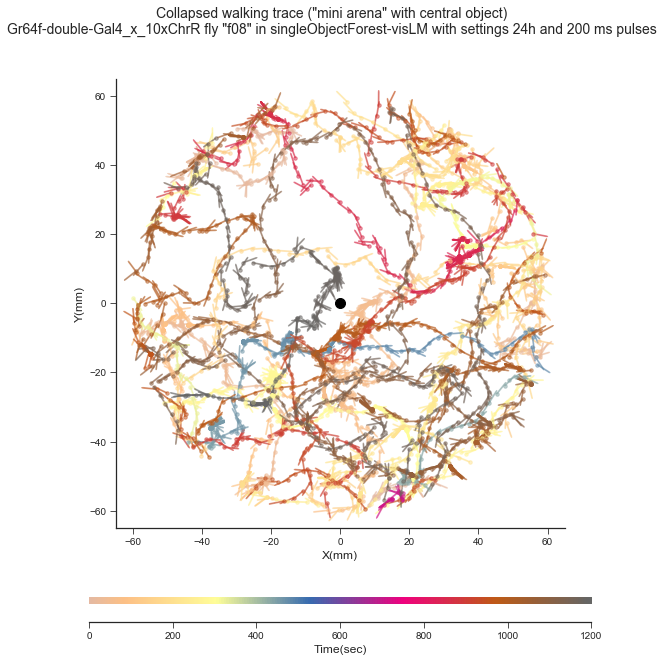

In [122]:
tStart = 0
tEnd = numFrames_ds
tStep = 4
frameRange = range(tStart, tEnd, tStep)
colMap = 'Accent'

colTrFig = plt.figure(figsize=(9, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=np.hstack((10, 1)))

colTrFig.suptitle('Collapsed walking trace ("mini arena" with central object)\n' + titleString, fontsize=14)

axTraj = colTrFig.add_subplot(gs[0])
axTime = colTrFig.add_subplot(gs[1])
plotPosInRange(axTraj, axTime, frameRange, time_ds, xPosMA_ds, yPosMA_ds, angle_ds, colMap, 4, 0.5, 7)  

axTraj.plot(0, 0, 'ko', markersize=10)
axTraj.set_ylim([-(5+arenaRad), arenaRad+5])
axTraj.set_xlim([-(5+arenaRad), arenaRad+5]) 

axTraj.set_xlabel(header[1], fontsize=12)
axTraj.set_ylabel(header[2], fontsize=12)

myAxisTheme(axTraj)

axTime.set_xlabel(header[0], fontsize=12)
plt.xlim((0, time_ds[-1]))
timeAxisTheme(axTime)

In [123]:
makeNestedPlotDirectory(analysisDir, 'tracePlotMA/', trialType + 'Trial'  + sep)

colTrFig.savefig(analysisDir + 'tracePlotMA/' + trialType + 'Trial'  + sep
                 + FODataFile[0:-4] + '_traceObjectPlot_ds.pdf', format='pdf')

Analysis directory already exists.
Plot directory already exists.


### Compute heading angle relative to closest object (use collapsed coordinates)
#### Compute parameters characterising fly's relationship to object

In [124]:
objLocation = [0, 0]
objDirection, objDistance, gammaFull, gamma, gammaV\
    = relationToObject(time_ds, xPosMA_ds, yPosMA_ds, angle_ds, objLocation)

### Save position and velocities for future analysis

In [125]:
toSave = {'time': time_ds,
          'xPos': xPos_ds,
          'yPos': yPos_ds,
          'xPosInMiniarena': xPosMA_ds,
          'yPosInMiniarena': yPosMA_ds,
          'headingAngle': angle_ds,
          'rotVelo': vRot_ds,
          'transVelo': vTrans_ds,
          'objectDistance': objDistance,
          'gammaFull': gammaFull,
          'gamma': gamma,
          'rEvents': rEvents_ds}

# Save data in this format as *.npy for easy loading..
np.save(expDir + FODataFile[:-4], toSave)